In [25]:
from sktime.forecasting.model_evaluation import evaluate
import numpy as np
import pandas as pd
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sktime.forecasting.base import ForecastingHorizon
import warnings

warnings.filterwarnings("ignore")

data = pd.read_csv("data/ENERGY_SETTLEMENT_PRICE.csv", index_col="TIME", parse_dates=["TIME"]).asfreq("H")

In [26]:
from typing import Optional
import pandas as pd

def split_series(y: pd.Series, train_end: str = "2022-01-01", test_len: Optional[int] = None, iterpolate: bool = True) -> tuple[pd.Series, pd.Series]:
    y = y.copy()
    if iterpolate:
        y = y.interpolate()
        
    train_mask = y.index < train_end    
    train = y.loc[train_mask]
    
    test = y.loc[~train_mask]
    if test_len is not None:
        test = test.iloc[:test_len]
        
    return train, test
    
train, test = split_series(data.squeeze(), test_len=365*24)

cv_data = pd.concat((train, test)).interpolate()

In [27]:
fh = ForecastingHorizon(list(range(1, 25)), is_relative=True)
splitter = ExpandingWindowSplitter(fh=fh, initial_window=len(train), step_length=24)

cv = splitter.split(cv_data)

In [32]:
from sktime.forecasting.naive import NaiveForecaster
from sktime.performance_metrics.forecasting import MeanAbsoluteError, MeanAbsolutePercentageError, MeanSquaredError
from app.modeling.backtesting import TSBacktesting

models = {
    "SEASONAL_NAIVE_MEAN": NaiveForecaster(strategy="mean", sp=24),
    "SEASONAL_NAIVE_MEAN_3_DAYS": NaiveForecaster(strategy="mean", sp=24, window_length=72),
    # "DRIFT": NaiveForecaster(strategy="drift"),
    # "EXP_SM00THING": ExponentialSmoothing(sp=12, trend="add", seasonal="add")
    # # "SEASONAL_NAIVE": NaiveForecaster(strategy="mean", sp=1, window_length=24),
    # "REGRESSION": make_reduction(estimator=LinearRegression(), window_length=3),
    # # "SES": ExponentialSmoothing(),
    # "AR_1": ARIMA(order=(3,0,0)),
    # "Theta": ThetaForecaster(sp=24)
    # "AR_24": ARIMA(order=(24,0,0))
}


bt = TSBacktesting(splitter, models=models)

In [34]:
bt.evaluate(cv_data)

,SEASONAL_NAIVE_MEAN,SEASONAL_NAIVE_MEAN_3_DAYS
2022-01-01 00:00:00,229.502671,458.186667
2022-01-01 01:00:00,220.318638,400.303333
2022-01-01 02:00:00,215.766335,350.760000
2022-01-01 03:00:00,212.637885,367.460000
2022-01-01 04:00:00,211.402697,328.120000
...,...,...
2022-12-31 19:00:00,408.349819,463.926667
2022-12-31 20:00:00,433.207655,439.070000
2022-12-31 21:00:00,415.828668,460.586667
2022-12-31 22:00:00,374.562471,459.890000


In [35]:
bt.errors_

,MAPE,MAE,RMSE
SEASONAL_NAIVE_MEAN,0.530975,416.038502,524.227277
SEASONAL_NAIVE_MEAN_3_DAYS,0.255310,170.883416,264.974262


In [ ]:
from abc import ABC, abstractmethod
from sktime.transformations.series.outlier_detection import HampelFilter
from typing import Optional
from datetime import datetime


class BaseTransformer(ABC):
    def fit(self, X: pd.DataFrame, y):
        return self
    
    @abstractmethod
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        ...        
    
class TrendCreator(BaseTransformer):
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        df = X.copy()
        df["TREND"] = np.arange(len(df))
        return df
    
class WeekendIndicatorCreator(BaseTransformer):
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        df = X.copy()
        df["WEEKEND"] = list(map(lambda x: int(x.day_of_week in {5, 6}), df.index))
        return df
    
class DayOfWeekIndicatorCreator(BaseTransformer):
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        df = X.copy()
        day = np.array([date.day_name() for date in df.index])
        day_dummies = pd.get_dummies(day, drop_first=True)
        day_dummies = day_dummies.set_index(df.index)
        df = pd.concat((df, day_dummies), axis=1)
        return df
    
class SeasonIndicatorCreator(BaseTransformer):
    def get_season(self, x: datetime) -> str:
        y = 2000
        x = x.replace(year=y)
        
        if x < datetime(y, 3, 21) or x > datetime(y, 12, 22):
            return "Winter"
        elif x < datetime(y, 6, 22):
            return "Spring"
        elif x < datetime(y, 9, 23):
            return "Summer"
        else:
            return "Autumn"
        
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        df = X.copy()
        season = np.array([self.get_season(x) for x in df.index])
        season_dummies = pd.get_dummies(season, drop_first=True)
        season_dummies = season_dummies.set_index(df.index)
        df = pd.concat((df, season_dummies), axis=1)
        return df
    
class DayOffIndicatorCreator(BaseTransformer):
    def __init__(self, file: str = "holidays.csv") -> None:
        self.file = file
        
    def _read_file(self) -> list:
        file = pd.read_csv(self.file, parse_dates=["Date"], usecols=["Date"])
        return file.squeeze().to_list()
        
    
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        df = X.copy()
        holidays = self._read_file()
        df["Is_Day_Off"] = list(map(lambda x: x.replace(hour=0) in holidays or x.day_name() in {"Sunday", "Suturday"}, df.index))
        return df

    
class LinearInterpolator(BaseTransformer):
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        df = X.copy()
        df["VALUE"] = df["VALUE"].interpolate()
        return df
    
    
class OutlierFlagCreator(BaseTransformer):
    def __init__(self, window_length: Optional[int] = None, return_bool: bool = True) -> None:
        self.window_length = window_length or (24 * 7)
        self.return_bool = return_bool
    
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        df = X.copy()
        hf = HampelFilter(window_length=self.window_length, return_bool=self.return_bool)
        out = hf.fit_transform(df["VALUE"])
        if self.return_bool:
            df["OUTLIER"] = list(map(int, out))
        else:
            df["VALUE"] = out
        return df

        

from sklearn.pipeline import Pipeline


pipe = Pipeline([
    ("interploate", LinearInterpolator()),
    # ("trend", TrendCreator()),
    ("season", SeasonIndicatorCreator()),
    ("weekend", WeekendIndicatorCreator()),
    ("day_of_week", DayOfWeekIndicatorCreator()),
    ("out", OutlierFlagCreator(return_bool=False))
])

X: pd.DataFrame = pipe.fit_transform(data)
X

,VALUE,Spring,Summer,Winter,WEEKEND,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
TIME,,,,,,,,,,,
2018-01-01 01:00:00,72.05,0,0,1,0,1,0,0,0,0,0
2018-01-01 02:00:00,72.05,0,0,1,0,1,0,0,0,0,0
2018-01-01 03:00:00,72.05,0,0,1,0,1,0,0,0,0,0
2018-01-01 04:00:00,72.05,0,0,1,0,1,0,0,0,0,0
2018-01-01 05:00:00,71.15,0,0,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2023-03-10 20:00:00,788.80,0,0,1,0,0,0,0,0,0,0
2023-03-10 21:00:00,786.00,0,0,1,0,0,0,0,0,0,0
2023-03-10 22:00:00,720.91,0,0,1,0,0,0,0,0,0,0


In [ ]:
train_X = X.loc[train.index]
test_X = X.loc[test.index]

mm = make_reduction(estimator=LinearRegression(), window_length=3)

mm.fit(train, train_X)

mm.predict(list(range(1, 100)), X=test_X)
mm.estimator_.coef_

array([-1.26882804e-02,  5.94548638e-02,  8.53621709e-01, -2.45189474e-03,
        8.76583873e-02, -6.96663185e-02, -9.60472352e-01, -5.67407449e+00,
        1.69354859e+00])

In [ ]:
X

,FUEL_PRICE,WEEKEND
TIME,,
2018-01-01 01:00:00,3651.0,0
2018-01-01 02:00:00,3651.0,0
2018-01-01 03:00:00,3651.0,0
2018-01-01 04:00:00,3651.0,0
2018-01-01 05:00:00,3651.0,0
...,...,...
2023-03-10 20:00:00,5364.0,0
2023-03-10 21:00:00,5364.0,0
2023-03-10 22:00:00,5364.0,0


In [ ]:
train_X.loc[train_X.isna().any(axis=1)]

,FUEL_PRICE,DEMAND,WEEKEND
TIME,,,
2018-03-25 03:00:00,3753.0,NaN,1
2019-03-31 03:00:00,4010.0,NaN,1
2020-01-01 01:00:00,3917.0,NaN,0
2020-01-01 02:00:00,3917.0,NaN,0
2020-01-01 03:00:00,3917.0,NaN,0
...,...,...,...
2021-01-31 23:00:00,3643.0,NaN,1
2021-02-01 00:00:00,3643.0,NaN,0
2021-02-10 23:00:00,3733.0,NaN,0


In [ ]:
X[X["DEMAND"].isna()].resample("M").sum()

,FUEL_PRICE,DEMAND,WEEKEND
TIME,,,
2018-03-31,3753.0,0.0,1
2018-04-30,0.0,0.0,0
2018-05-31,0.0,0.0,0
2018-06-30,0.0,0.0,0
2018-07-31,0.0,0.0,0
2018-08-31,0.0,0.0,0
2018-09-30,0.0,0.0,0
2018-10-31,0.0,0.0,0
2018-11-30,0.0,0.0,0


In [ ]:
mm.estimator_.coef_, mm.estimator_.intercept_

(array([-1.85140283e-04,  6.19974111e-02,  8.66622974e-01]),
 18.718025390632903)

In [ ]:
mm.predict(fh=np.arange(1, 24))

2022-01-01 00:00:00    409.651936
2022-01-01 01:00:00    398.356350
2022-01-01 02:00:00    387.922134
2022-01-01 03:00:00    378.283603
2022-01-01 04:00:00    369.380079
2022-01-01 05:00:00    361.155513
2022-01-01 06:00:00    353.558129
2022-01-01 07:00:00    346.540101
2022-01-01 08:00:00    340.057248
2022-01-01 09:00:00    334.068760
2022-01-01 10:00:00    328.536937
2022-01-01 11:00:00    323.426955
2022-01-01 12:00:00    318.706647
2022-01-01 13:00:00    314.346296
2022-01-01 14:00:00    310.318453
2022-01-01 15:00:00    306.597762
2022-01-01 16:00:00    303.160801
2022-01-01 17:00:00    299.985933
2022-01-01 18:00:00    297.053172
2022-01-01 19:00:00    294.344054
2022-01-01 20:00:00    291.841527
2022-01-01 21:00:00    289.529835
2022-01-01 22:00:00    287.394427
Name: VALUE, dtype: float64

In [ ]:
pd.DataFrame(d)

,SEASONAL_NAIVE_MEAN,SEASONAL_NAIVE_MEAN_3_DAYS
MAPE,0.530975,0.255310
MAE,416.038502,170.883416
MSE,274814.237883,70211.359476
RMSE,524.227277,264.974262


In [ ]:
vals["ACTUAL"] = valid_data
vals

,MA_LAST_DAY,DRIFT,LAST,REGRESSION,AR_1,Theta,ACTUAL
2022-01-01 00:00:00,242.282083,421.889977,421.88,406.819740,406.818360,379.788314,396.28
2022-01-01 01:00:00,242.282083,421.899955,421.88,397.365455,397.362007,362.037553,70.00
2022-01-01 02:00:00,242.282083,421.909932,421.88,388.227722,388.218102,354.126579,70.00
2022-01-01 03:00:00,242.282083,421.919910,421.88,379.725399,379.710809,349.004344,150.00
2022-01-01 04:00:00,242.282083,421.929887,421.88,371.792325,371.773219,346.708059,150.00
...,...,...,...,...,...,...,...
2022-01-30 19:00:00,507.706667,489.083123,488.85,328.299475,328.242428,558.617943,546.59
2022-01-30 20:00:00,507.706667,489.094779,488.85,324.510949,324.453509,573.581549,529.74
2022-01-30 21:00:00,507.706667,489.106435,488.85,320.958522,320.900786,553.000500,546.59
2022-01-30 22:00:00,507.706667,489.118091,488.85,317.627481,317.569536,505.970715,496.12


<AxesSubplot: xlabel='TIME'>

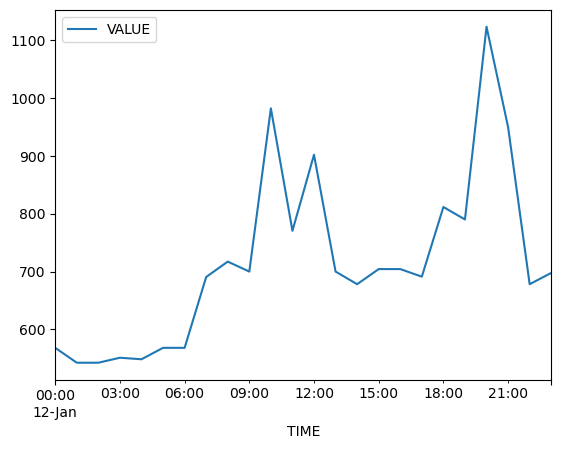

In [ ]:
day = 11

day_data = valid_data.iloc[24 * day: 24 * (day + 1)]
day_data.plot()

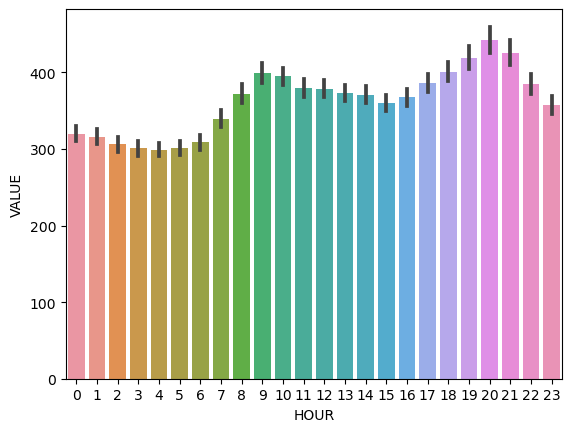

In [ ]:
import seaborn as sns

data["HOUR"] = data.index.hour
data["MONTH"] = data.index.month
data["YEAR"] = data.index.year
data["MONTH_DAY"] = str(data.index.month) + str(data.index.day) 

sns.barplot(data, x="HOUR", y="VALUE");

In [ ]:
sns.barplot(data, x="MONTH_DAY", y="VALUE");

NameError: name 'sns' is not defined

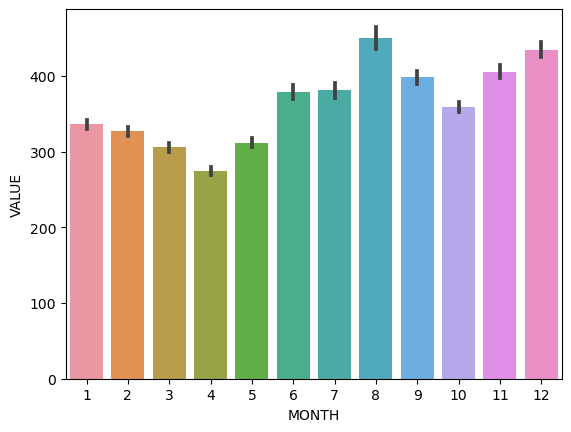

In [ ]:
sns.barplot(data, x="MONTH", y="VALUE");

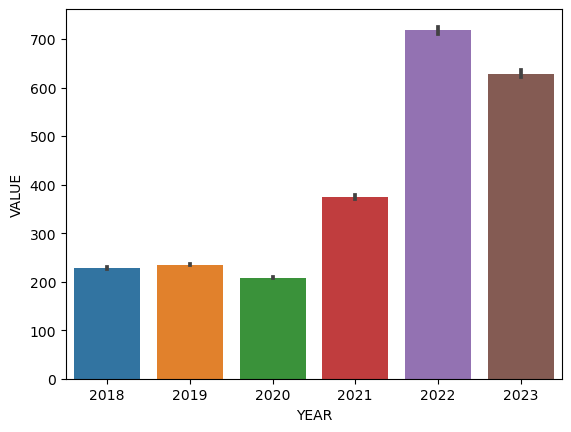

In [ ]:
sns.barplot(data, x="YEAR", y="VALUE");

In [ ]:
f = data.groupby("DAY_OF_YEAR")["VALUE"].mean().sort_values(ascending=False)
f.loc[3]

240.50408333333334

In [ ]:
from sktime.transformations.series.outlier_detection import HampelFilter

hf = HampelFilter(window_length=24*7)
corr = hf.fit_transform(data["VALUE"])

hf = HampelFilter(window_length=24*7, return_bool=True)
flag = hf.fit_transform(data["VALUE"])

In [ ]:
data["OUTLIER"] = list(map(int, flag))
data

,VALUE,HOUR,MONTH,YEAR,DAY_OF_YEAR,OUTLIER
TIME,,,,,,
2018-01-01 01:00:00,72.05,1,1,2018,1,0
2018-01-01 02:00:00,72.05,2,1,2018,1,0
2018-01-01 03:00:00,72.05,3,1,2018,1,0
2018-01-01 04:00:00,72.05,4,1,2018,1,0
2018-01-01 05:00:00,71.15,5,1,2018,1,0
...,...,...,...,...,...,...
2023-03-10 20:00:00,788.80,20,3,2023,69,0
2023-03-10 21:00:00,786.00,21,3,2023,69,0
2023-03-10 22:00:00,720.91,22,3,2023,69,0


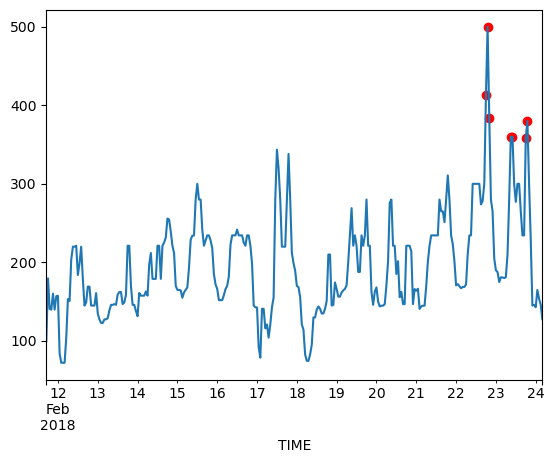

In [ ]:
from matplotlib import pyplot as plt

ch = data.iloc[1000: 1300]
ch["VALUE"].plot()
ot = ch.loc[ch["OUTLIER"] == 1]
plt.scatter(ot.index, ot["VALUE"], c='r')

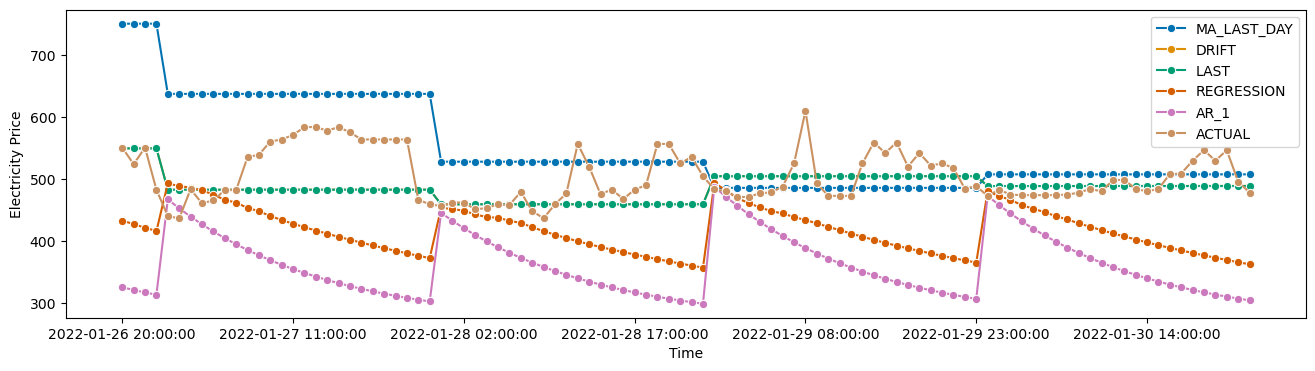

In [ ]:
from matplotlib import pyplot as plt
from sktime.utils.plotting import plot_series


plot_series(*map(lambda x: vals[x].iloc[-100:], vals.columns), labels= vals.columns.to_list(), y_label='Electricity Price', x_label='Time');

# plt.plot(valid_data)
# vals.plot()


In [ ]:
vals.T.values

array([[242.28208333, 242.28208333, 242.28208333, ..., 660.95458333,
        660.95458333, 660.95458333],
       [421.88997747, 421.89995494, 421.90993241, ..., 614.88106365,
        614.89565745, 614.91025125],
       [421.88      , 421.88      , 421.88      , ..., 614.56      ,
        614.56      , 614.56      ]])